<a href="https://colab.research.google.com/github/Ignacioruuizm/BD_MACHINE_CS_EV4/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Informe Técnico - Examen Transversal: Caso Counter Strike

# Importaciones específicas para SVM

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, roc_curve, roc_auc_score)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Cargar los datos
from google.colab import files
uploaded = files.upload()

# Leer el archivo CSV
df = pd.read_csv('Anexo_ET_demo_round_traces_2022_corregido.csv', low_memory=False)

# Eliminar columna de índice innecesaria si existe
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

Saving Anexo_ET_demo_round_traces_2022_corregido.csv to Anexo_ET_demo_round_traces_2022_corregido (4).csv


Preparacion de datos

In [28]:
# 3. Asignación segura de nombres de columnas
column_names = [
    'PlayerId', 'Map', 'Team', 'InternalTeamId', 'MatchId', 'RoundId', 'RoundWinner',
    'MatchWinner', 'Survived', 'AbnormalMatch', 'TimeAlive', 'TravelledDistance',
    'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown', 'PrimaryAssaultRifle',
    'PrimarySniperRifle', 'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol', 'FirstKillTime',
    'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills',
    'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue', 'MatchKills',
    'MatchFlankKills', 'MatchAssists', 'MatchHeadshots'
]

if len(df.columns) == len(column_names):
    df.columns = column_names
    print("\n🔄 Nombres de columnas asignados correctamente")
else:
    print("\nℹ️ El DataFrame ya tiene nombres de columnas válidos")

# 4. Selección y verificación de características
features = [
    'TeamStartingEquipmentValue',
    'RoundStartingEquipmentValue',
    'TimeAlive',
    'TravelledDistance',
    'RoundAssists',
    'RoundHeadshots'
]

# Verificación de columnas existentes
missing_cols = [col for col in features + ['MatchKills'] if col not in df.columns]
if missing_cols:
    print(f"\n⚠️ Columnas faltantes: {missing_cols}")
    print("Columnas disponibles:", df.columns.tolist())
    raise ValueError("Algunas columnas necesarias no existen en el DataFrame")

# 5. Conversión segura a numérico
print("\n🔢 Convirtiendo columnas a numérico...")
df[features + ['MatchKills']] = df[features + ['MatchKills']].apply(
    pd.to_numeric, errors='coerce')

# 6. Limpieza de datos nulos
initial_count = len(df)
df_clean = df.dropna(subset=features + ['MatchKills']).copy()  # Usar .copy() para evitar el warning
removed_count = initial_count - len(df_clean)

print(f"\n🧹 Datos limpiados:")
print(f"• Filas originales: {initial_count}")
print(f"• Filas eliminadas (valores nulos): {removed_count}")
print(f"• Filas restantes: {len(df_clean)}")

# 7. Creación de variable objetivo
df_clean.loc[:, 'HighKills'] = (df_clean['MatchKills'] >= 5).astype(int)
kill_dist = df_clean['HighKills'].value_counts(normalize=True) * 100

print("\n🎯 Distribución de la variable objetivo:")
print(f"• HighKills=0: {kill_dist[0]:.1f}%")
print(f"• HighKills=1: {kill_dist[1]:.1f}%")

# 8. Balanceo de clases (solo si es necesario)
balance_threshold = 1.5  # Ratio máximo aceptable entre clases
needs_balance = kill_dist[0] / kill_dist[1] > balance_threshold

if needs_balance:
    print("\n⚖️ Aplicando balanceo de clases...")
    df_majority = df_clean[df_clean['HighKills'] == 0]
    df_minority = df_clean[df_clean['HighKills'] == 1]

    df_minority_upsampled = resample(
        df_minority,
        replace=True,
        n_samples=len(df_majority),
        random_state=42
    )

    df_balanced = pd.concat([df_majority, df_minority_upsampled])
    print("✅ Balanceo completado")
    print("\n📊 Nueva distribución:")
    print(df_balanced['HighKills'].value_counts(normalize=True))
else:
    df_balanced = df_clean
    print("\nℹ️ Las clases están razonablemente balanceadas, no se aplicó balanceo")

# 9. Resultados finales
print("\n🎉 Preparación de datos completada:")
print(f"• Total de filas finales: {len(df_balanced)}")
print("\n📋 Vista previa de los datos preparados:")
print(df_balanced[features + ['MatchKills', 'HighKills']].head())

# 10. Exportación opcional
try:
    df_balanced.to_csv('counter_strike_cleaned_data.csv', index=False)
    print("\n💾 Datos guardados en 'counter_strike_cleaned_data.csv'")
except Exception as e:
    print(f"\n⚠️ No se pudo guardar el archivo: {str(e)}")


ℹ️ El DataFrame ya tiene nombres de columnas válidos

🔢 Convirtiendo columnas a numérico...

🧹 Datos limpiados:
• Filas originales: 70
• Filas eliminadas (valores nulos): 0
• Filas restantes: 70

🎯 Distribución de la variable objetivo:
• HighKills=0: 60.0%
• HighKills=1: 40.0%

ℹ️ Las clases están razonablemente balanceadas, no se aplicó balanceo

🎉 Preparación de datos completada:
• Total de filas finales: 70

📋 Vista previa de los datos preparados:
     TeamStartingEquipmentValue  RoundStartingEquipmentValue  TimeAlive  \
230                        9000                         1800        0.0   
231                        9000                         4700        0.0   
235                       25400                         5500        0.0   
237                       25400                         5200        0.0   
238                       25400                         5100        0.0   

     TravelledDistance  RoundAssists  RoundHeadshots  MatchKills  HighKills  
230            

Division, Estandarizacion y Entrenamiento modelo

In [29]:
# División de datos
X = df_balanced[features]
y = df_balanced['HighKills']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento del modelo SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True, random_state=42)

Visualizacion y resultados

### 🔍 Resultados para SVM ###
🔍 Accuracy: 0.7143

📌 Matriz de Confusión:
[[6 3]
 [1 4]]

📄 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.57      0.80      0.67         5

    accuracy                           0.71        14
   macro avg       0.71      0.73      0.71        14
weighted avg       0.76      0.71      0.72        14



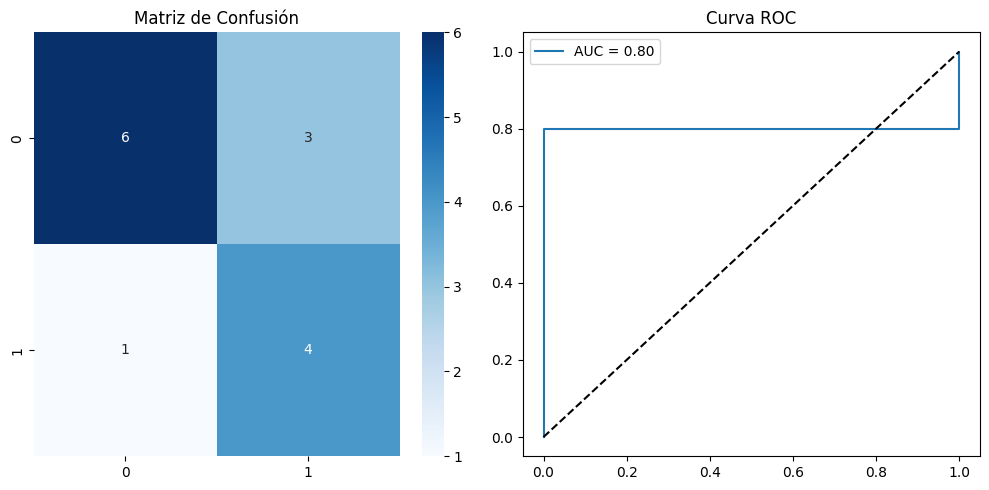

In [30]:
# Evaluación
y_pred = svm_model.predict(X_test_scaled)
y_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

# Resultados
print("### 🔍 Resultados para SVM ###")
print(f"🔍 Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")

print("📌 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\n📄 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')

plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.legend()
plt.tight_layout()
plt.show()